In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import LSTM, Dense, Input, Flatten
from tensorflow.keras.models import Model

In [2]:
# Define paths to the folders
real_videos_path = "test-real"
deepfake_videos_path = 'test-fake'

# Initialize lists to store file names and labels
file_names = []
labels = []

# Label real videos with 0
for video in os.listdir(real_videos_path):
    file_names.append(os.path.join(real_videos_path, video))
    labels.append(0)

# Label deepfake videos with 1
for video in os.listdir(deepfake_videos_path):
    file_names.append(os.path.join(deepfake_videos_path, video))
    labels.append(1)

labels= np.array(labels)
# Create a DataFrame
data = pd.DataFrame({'file_name': file_names, 'label': labels})

# Save to a CSV file
data.to_csv('video_labels.csv', index=False)
# file_paths = np.asarray(file_names)




In [3]:
def plot_frames(frames_list):
    num_frames = len(frames_list)
    
    if num_frames == 0:
        print("No frames to display.")
        return
    
    # Plot the frames
    plt.figure(figsize=(12, 6))
    for i, frame in enumerate(frames_list):
        plt.subplot(1, num_frames, i + 1)
        plt.imshow(frame)
        plt.axis('off')
       # plt.title(f"Frame {i + 1}")
    
    plt.show()

In [4]:
# Constants
# SEQUENCE_LENGTH = 10
IMAGE_HEIGHT = 255
IMAGE_WIDTH = 255

def extract_frames(video_path,num_frames):
    frames = []
    
    # Read the Video File using the VideoCapture object
    video_reader = cv2.VideoCapture(video_path)
    
    # Check if the video file was opened successfully
    if not video_reader.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return frames_list
    
    # Get the total number of frames in the video
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate the interval after which frames will be added to the list
    skip_frames_window = max(int(video_frames_count / num_frames), 1)
    
    # Iterate through the video frames
    for frame_counter in range(num_frames):
        # Set the current frame position of the video
        frame_pos = frame_counter * skip_frames_window
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_pos)
        
        # Read the frame from the video
        success, frame = video_reader.read()
        
        # Check if the video frame was successfully read
        if not success:
            print(f"Warning: Frame at position {frame_pos} could not be read.")
            continue
        
        # Resize the frame to fixed height and width
        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        
        # Normalize the resized frame by dividing it by 255 so that each pixel value lies between 0 and 1
        # normalized_frame = resized_frame / 255.0
        
        # Append the normalized frame to the frames list
        frames.append(resized_frame)
    # Release the VideoCapture object
    video_reader.release()
    frames_list = np.array(frames)
    return frames_list


In [5]:
# def video_file(file_names):
#     features = []
#     # labels = []
#     # video_files_paths = []
#     # Iterate through the list of file names
#     for file_name in file_names:  # Assuming the video file path is in the first column
#         # Get the complete video path
#         # video_file_path = os.path.join(DATASET_DIR, file_name)

#         # Extract frames from the video file
#         frames = frames_extraction(file_name[0,0])
#         # Check if the extracted frames meet the specified sequence length
#         if len(frames) == SEQUENCE_LENGTH:
#             features.append(frames)
#             # labels.append(file_names[0, -1])  # Assuming the label is in the last column
#             # video_files_paths.append(video_file_path)
    
#     # Convert lists to numpy arrays
#     features = np.asarray(features)
#     # labels = np.array(labels)
    
#     return features


In [6]:
def extract_features(frames, xception_model):
    features = xception_model.predict(frames)
    return features


In [7]:
def load_xception_model():
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(255, 255, 3))
    x = base_model.output
    x = Flatten()(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.trainable = False
    return model


In [8]:
def create_model(sequence_length, feature_size):
    # Define inputs
    video_input = Input(shape=(sequence_length, feature_size))
    
    # Add LSTM layer
    x = LSTM(128, return_sequences=False)(video_input)
    
    # Add dense layer for classification
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    
    # Create model
    model = Model(inputs=video_input, outputs=output)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [9]:
def main(video_paths, labels, num_frames=10):
    # Load Xception model for feature extraction
    xception_model = load_xception_model()
    
    features = []
    for video_path in video_paths:
        frames = extract_frames(video_path, num_frames)
        if len(frames) == num_frames:
            feature = extract_features(frames, xception_model)
            features.append(feature)
    
    features = np.array(features)
    labels = np.array(labels)
    
    # Define and compile the LSTM model
    model = create_model(sequence_length=num_frames, feature_size=features.shape[-1])
    
    # Train the model
    hist = model.fit(features, labels, epochs=10, batch_size=16, validation_split=0.2)
    
    # Evaluate the model (optional)
    # scores = model.evaluate(features, labels)
    # print(f"Model Accuracy: {scores[1] * 100:.2f}%")
    return hist
# Example usage
# video_paths = ["video1.mp4", "video2.mp4"]  # List of video file paths
# labels = [0, 1]  # Corresponding labels (0 for real, 1 for fake)
# main(video_paths, labels)


In [10]:
file_address = pd.read_csv("video_labels.csv")

address = file_address.iloc[:,0]
labels = file_address.iloc[:,1]
address = np.array(address)
labels = np.array(labels)
print ("File loaded")
hist = main(address,labels,10)

File loaded
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━

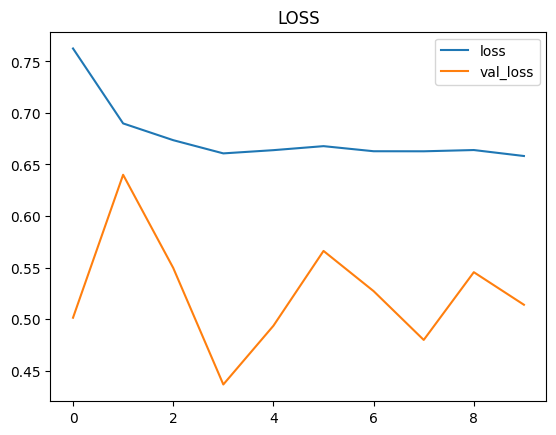

In [11]:
plt.plot(hist.history['loss'] , label = 'loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.title('LOSS')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import LSTM, Dense, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import preprocess_input

# Define paths to the folders
real_videos_path = "test-real"
deepfake_videos_path = 'test-fake'

# Initialize lists to store file names and labels
file_names = []
labels = []

# Label real videos with 0
for video in os.listdir(real_videos_path):
    file_names.append(os.path.join(real_videos_path, video))
    labels.append(0)

# Label deepfake videos with 1
for video in os.listdir(deepfake_videos_path):
    file_names.append(os.path.join(deepfake_videos_path, video))
    labels.append(1)

labels = np.array(labels)
data = pd.DataFrame({'file_name': file_names, 'label': labels})
data.to_csv('video_labels.csv', index=False)

# Constants
IMAGE_HEIGHT = 255
IMAGE_WIDTH = 255

def extract_frames(video_path, num_frames):
    frames = []
    video_reader = cv2.VideoCapture(video_path)
    if not video_reader.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return frames

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / num_frames), 1)

    for frame_counter in range(num_frames):
        frame_pos = frame_counter * skip_frames_window
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_pos)
        success, frame = video_reader.read()
        if not success:
            print(f"Warning: Frame at position {frame_pos} could not be read.")
            continue
        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        frames.append(resized_frame)
    video_reader.release()
    frames = np.array(frames)
    print(f"Extracted {len(frames)} frames from {video_path}")
    return frames

def preprocess_frames(frames):
    frames = np.array(frames)
    frames = preprocess_input(frames)
    return frames

def extract_features(frames, xception_model):
    frames = preprocess_frames(frames)
    features = xception_model.predict(frames, batch_size=32)
    return features

def load_xception_model():
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    x = base_model.output
    x = Flatten()(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.trainable = False
    return model

def create_model(sequence_length, feature_size):
    video_input = Input(shape=(sequence_length, feature_size))
    x = LSTM(128, return_sequences=False)(video_input)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=video_input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def main(video_paths, labels, num_frames=10):
    xception_model = load_xception_model()
    features = []

    for video_path in video_paths:
        frames = extract_frames(video_path, num_frames)
        if len(frames) == num_frames:
            feature = extract_features(frames, xception_model)
            features.append(feature)

    features = np.array(features)
    labels = np.array(labels)
    
    # Ensure features have correct shape
    if len(features) == 0:
        raise ValueError("No valid features were extracted. Check video files and frame extraction.")
    
    model = create_model(sequence_length=num_frames, feature_size=features.shape[-1])
    
    hist = model.fit(features, labels, epochs=10, batch_size=16, validation_split=0.2)
    return hist

# Load CSV and run main function
file_address = pd.read_csv("video_labels.csv")
address = file_address['file_name'].values
labels = file_address['label'].values
print("File loaded")
hist = main(address, labels, 10)


File loaded
Extracted 10 frames from test-real\00000.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Extracted 10 frames from test-real\00001.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Extracted 10 frames from test-real\00002.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Extracted 10 frames from test-real\00003.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Extracted 10 frames from test-real\00004.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Extracted 10 frames from test-real\00005.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Extracted 10 frames from test-real\00006.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Extracted 10 frames from test-real\00007.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Extracted 10 frames from test-real\00008.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Extracted 10 frames from test-real\00009.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Extracted 10 frames from test-real\00010.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Extracted 10 frames from test-real\00011.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Extracted 10 fra